<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_2/yYGiBqtirSM.jpg" height="300" width="300"> 

# <center> R для тервера и матстата. <br>  <br> 2. Варка распределений, ЗБЧ, метод Монте-Карло. </center>

Данный ноутбук является конспектом по курсу «R для теории вероятностей и математической статистики» (РАНХиГС, 2017-2018). Автор ноутбука [вот этот парень по имени Филипп.](https://vk.com/ppilif) Если у вас для него есть деньги, слава или женщины, он от этого всего не откажется. Ноутбук распространяется на условиях лицензии [Creative Commons Attribution-Share Alike 4.0.](https://creativecommons.org/licenses/by-sa/4.0/) При использовании обязательно упоминание автора курса и аффилиации. При наличии технической возможности необходимо также указать активную гиперссылку на [страницу курса.](https://fulyankin.github.io/R_probability/) На ней можно найти другие материалы. Фрагменты кода, включенные в этот notebook, публикуются как [общественное достояние.](https://creativecommons.org/publicdomain/zero/1.0/)

---------

В этой терадке мы поговорим о варке распределений, методе монтекрало и законе больших чисел. Будет мног симуляций. Добро пожаловать. Уже традиционно, начнём с подгрузки пакетов, часть из которых при работе в RStusio можно проигнорировать. 

In [3]:
library("ggplot2")  # Пакет для красивых графиков 
library("grid")     # Пакет для субплотов


# Эти пакеты для Rstudio не очень то и нужны 
# Отрегулируем размер картинок, которые будут выдаваться в нашей тетрадке
library('repr')
options(repr.plot.width=4, repr.plot.height=3)

## 1. Варка распределений

Помните задачку $7.1$ и задачку $7.2$ из домашнего задания? Пришло время понять что за тайна скрывается за этими двумя задачами! Для начала, давайте разберёмся как они решаются. 

### Задачка 7.1 

Пусть $X \sim Exp(2)$. Аня помнит, что такое распределение называется экспоненциальным и что в такой ситуации функция распределения случайной величины $X$ выглядит как: 

$$ F(x) = 1 - e^{-2 x}$$

Аня хочет понять какое распределение будет у случайной величины $Y$, если 

$$ Y = 1 - e^{-2 X}$$ 

Попробуйте ссимулировать такую случайную величину, посмотреть на её гистограмму и дать ответ на вопрос Ани. Подумайте почему ответ получился именно таким.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


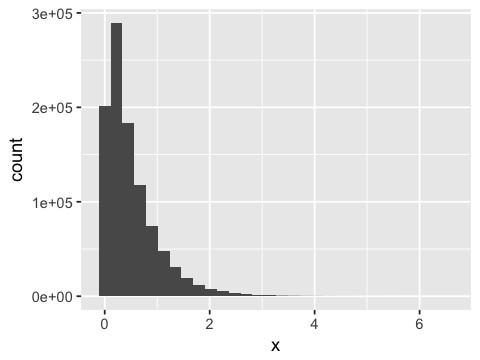

In [4]:
x <- rexp(10^6, rate = 2)
qplot(x)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


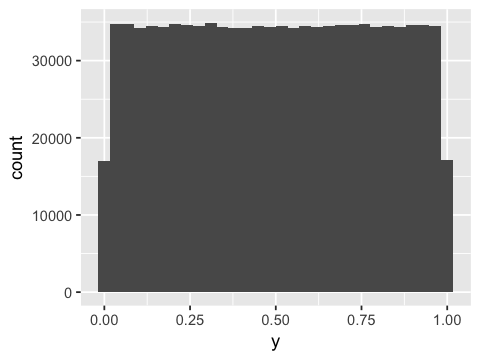

In [5]:
y <- 1 - exp(-2*x)
qplot(y)

### Задачка 7.2

Маша и Виолетта живут в общежитии в одной комнате. Маша постоянно что-то говорит про нейронные сети. Виолетта не очень понимает о чём идёт речь, но хотела бы разобраться, чтобы быть с подругой на одной волне. Для этого она залезла в [мудрую книгу](https://yadi.sk/i/wBswqtL33UDYsD) и стала читать. В одной из первых глав она узнала, что в качестве функции активации в нейронах часто используют сигмоида, которая представляет из себя функцию распределения для логистической случайной величины. Функция выглядит как-то так: 

$$ F(x) = \frac{1}{1 + e^{-x}} $$

Виолетта пока не поняла что такое нейрон, сигмоида и функция активации, зато она очень хорошо знает что такое распределение случайной величины. Ей жутко интересно как оно выглядит.

а) Помогите Виолетте сгенирировать случайную величину $X$, имеющую логистическое распределение. Постройте для неё гистограмму, плотность и функцию распределения прямо как на паре. 

б) Также Виолетте хотелось бы узнать какое распределение будет у случайной величины $Y = F(X)$. Попробуйте посмотреть на него с помощью симуляций. Как следует подумайте почему ответ получился именно таким. Функция `rlogis` с параметрами `location = 0` и  `scale = 1` вам в помощь! 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


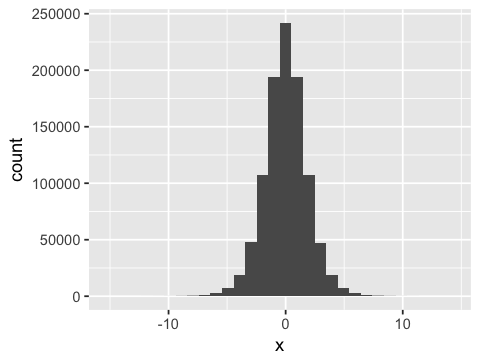

In [6]:
x <- rlogis(10^6, location = 0, scale = 1)
qplot(x)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


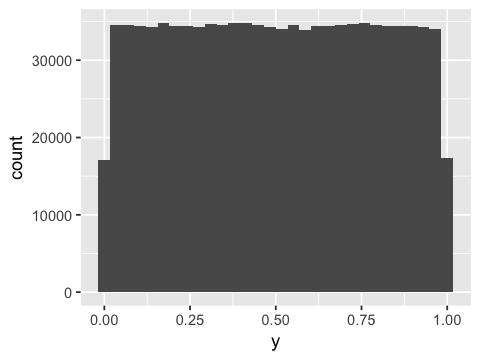

In [7]:
y <- 1/(1 + exp(-x))
qplot(y)

Дважды у нас получилось равномерное распределение. Знакомьтесь с ещё одной интересной теоремой, которая наравне с ЗБЧ и ЦПТ позволяет нам делать многие интересные вещи. 

#### Теорема:

Пусть функция распределения $F_X(x)$ непрерывна. Тогда случайная величина $Y = F(X)$ имеет равномерное распределение на отрезке $[0; 1]$.

___Доказательство:___

Найдём функцию распределения случайной величины $Y$. Заметим, что всегда $0 \le Y \le 1$ в силу области определения функции распределения $F(x)$. Предположим сначала, что функция $F$ всюду возрастает, тогда она обратима и поэтому: 

$$
F_Y(y) = P(F(X) < y) = P(X < F^{-1}(y)) = F(F^{-1}(y)) = y, \text{ если } x \in (0,1).
$$

При этом мы знаем, что функция распределения $F(y) = y$ соответствует равномерному на отрезке $[0;1]$ распределению. 

Если функция $F$ не является всюду возрастающей, то у неё есть участки постоянства.В этом случае просто обозначим через $F^{-1}(y)$ самую левую точку из замкнутого множества $\{t \mid F(t) = x\}$. При таком понимании обратной функции все равенства, перичесленные выше, остаются справедливы. 

___ч.т.д.___ 

Это многое объясняет. Давайте посмотрим на нашу теорему немного с другой стороны. 

___Cледствие:___

Пусть $Y \sim U[0;1]$, а $F$ — произвольная функция распредения. Тогда случайная величина $X = F^{-1}(Y)$ (квантильное преобразование над $Y$) имеет функцию распределения $F$.

На лекции мы с вами обсудили, что генерация случайностей это довольно сложное занятие. Равномерная случайная величина одна из самых приятных в плане генерации. Обычно алгоритмы генерации создают именно для неё, так как с более сложными распределениями возникают проблемы.  Квантильное преобразование позволяет нам расширить навыки компьютера и переработать равномерную случайную величину в необходимое нам распределение. Снова математика позволила нам быть клёвыми. Приятно. 

Как же мы можем сварить из равномерной случайной величины, $U[0; 1]$  экспоненциальную величину, $Exp(\alpha)$? Легко! 

$$
F_X(x) = 1 - e^{-\alpha x}
$$

$$
F_X^{-1}(y) = -\frac{1}{\alpha} \ln(1-y). 
$$

Все выкладки проведены, давайте варить!

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


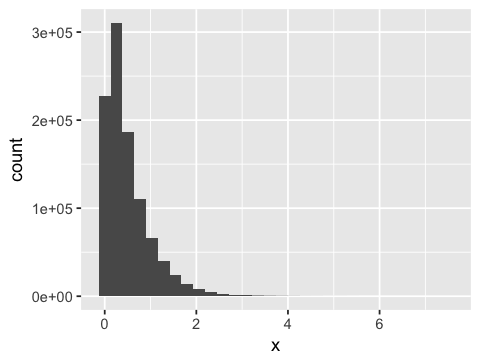

In [8]:
y <- runif(10^6, min = 0, max = 1)
x <- -0.5*log(1-y)
qplot(x)

Вот и все дела. Аналогично можно попробовать получить какую-нибудь случайно величину с заранее известной функцией распределения. Давайте попробуем получить случайную величину со следующей функцией распределения: 

$$
F(x) = \begin{cases} 0, x < 0 \\ x^7, x \in [0,1] \\ 1, x > 1 \end{cases}
$$

Согласитесь, найти обратную функцию здесь довольно просто... 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


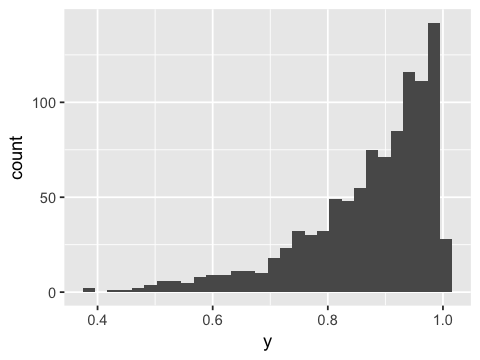

In [9]:
y = runif(1000, min = 0, max = 1)
x = y^(1/7)
qplot(x)

Ясное дело, что работать такая схема будет не всегда. Например, её никогда не используют для нормального распределения. Проблема в том, что подсчет обратной функции распределения для него аналитически невозможен, так как интеграл 


$$ 
F(x) = \int_{-\infty}^{x} \frac{1}{\sigma \sqrt{2 \pi}} \cdot e^{-\frac{(t-\mu)^2}{2 \sigma^2}} dt
$$

не берётся. Немного подробнее про разные генераторы случайных чисел можно [почитать на хабре.](https://habrahabr.ru/post/263993/)

## 2. Закон больших чисел

<img src="https://raw.githubusercontent.com/FUlyankin/r_probability/master/end_seminars/sem_2/dori.jpeg" height="500" width="500"> 


### 2.1 Игра в кости

В презентации мы увидели забавную [иллюстрацию ЗБЧ, взятую с википедии.](https://ru.wikipedia.org/wiki/Закон_больших_чисел) Давайте попробуем воспроизвести её в R! 

Итак, у нас есть игральная кость. Нам хочется узнать какое среднее значение на ней будет выпадать при увеличении количества бросков. Напишем цикл, который будет симулировать подбрасывание кости и записывать среднее значение в заранее заготовленный вектор.

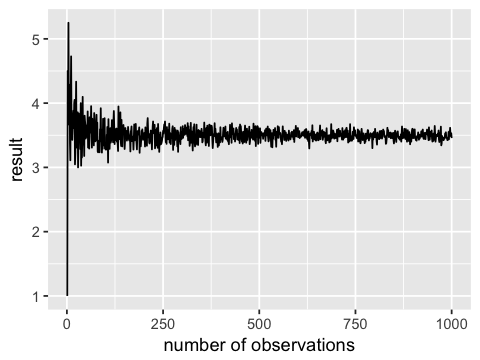

In [10]:
n_obs = 1000
kubik = rep(0, n_obs)

for(n in 1:n_obs){ # n - количество подбрасываний кубика
    
    # Сделали выборку 
    smpl = sample(1:6, size = n, replace = TRUE)
    
    # Подсчитали среднее значение и запомнили его 
    kubik[n] = mean(smpl)   
}

qplot(1:1000, kubik, geom='line', xlab='number of observations', ylab='result')

Мы видим, что cреднее значение, выпадающее на кости, сходится по вероятности к истиному математическому ожиданию, о чём нам и говорит ЗБЧ.

### 2.2  Страховка

Закон больших чисел — это теорема, которая позволяет людям зарабатывать деньги! В 1600-х годах люди научились состовлять актуарные таблицы. Это такие таблицы, где указана ожидаемая продолжительность жизни для данного возраста и пола. Люди начали собирать данные о смертности и оценивать вероятность дожития человека до определённого возраста. На этом строились тарифы на страхование. 

Появление подобных таблиц обязано зарождению в течение 1600-х годов теории вероятности, которая впервые объяснила людям как случайные вещи при достаточно больших масштабах сглаживаются и становятся очень даже предсказуемыми. Надо признать, что у страхования было довольно трудное детство — как раз потому, что люди плоховато понимали концепцию вероятности. В голове довольно трудно удержать её. Многие люди и по сей день ошибочно думают, что могут влиять на случайность каким-то образом. Например, некоторые думают, что чаще других выбрасывают на кубике шестёрки. Более того, люди довольно плохо понимают условные вероятности. 

Несмотря на всё это недопонимание, страховые компании в наше время на диверсификации рисков делают довольно неплохой бизнес. Текущее упражнение призвано показать как примерно это происходит. Давайте представим, что мы с вами решили запилить свой собственный бизнес, связанный со страховками.

Конечно же бизнес мы будем делать в России. Для того, чтобы как следует сделать его, мы нашли [актуарные таблицы для России 2009 года выпуска.](https://yadi.sk/i/-k-9kB263Uv8uH)

In [11]:
df = read.csv('data/aktuar2009.csv', sep=';', dec=',')
head(df)

X,Мужчины.и.женщины.город,Мужчины.город,Женщины.город,Мужчины.и.женщины.село,Мужчины.село,Женщины.село
0 лет,0.992525,0.991658,0.993442,0.990321,0.989209,0.991496
1 год,0.999307,0.999221,0.999397,0.998812,0.998709,0.998921
2 года,0.999558,0.999517,0.999601,0.999358,0.999298,0.999420
3 года,0.999668,0.999609,0.999730,0.999441,0.999288,0.999601
4 года,0.999700,0.999671,0.999731,0.999524,0.999445,0.999607
5 лет,0.999695,0.999636,0.999757,0.999515,0.999444,0.999589


Посмотрим на то как в России выживается женщинам и мужчинам.

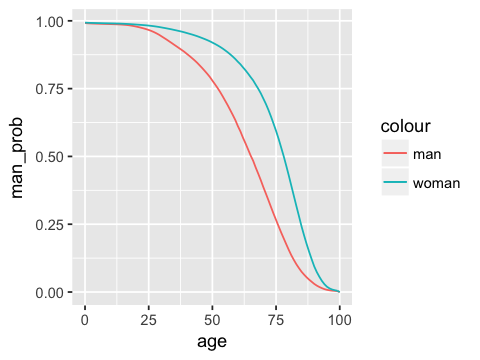

In [12]:
df['age'] = 0:100
df['man_prob'] = cumprod(df[,3])   # вероятность дожить до какого-то возраста
df['woman_prob'] = cumprod(df[,4])

ggplot(df, aes(age))+
    geom_line(aes(y=man_prob, colour = "man"))+
    geom_line(aes(y=woman_prob, colour = "woman"))

Красота спасёт мир! Давайте застрахуем мир от гибели. Предположим, что наша страховая компания собирается страховать жизни красивых девушек. Страховки продаются на год. Только девушкам возраста от 20 до 60. Для каждого возраста надо установить некоторую величину страхового взноса. Давайте попробуем найти минимально допустимую величину для каждого возраста. Для этого решим небольшую подготовительную задачку. 

__Подготовительная задачка:__ 

Пусть для 25-летней девушки вероятность прожить ещё год составляет $0.9$. Страховка на год стоит $1000$ рублей при взносе в $110$ рублей. Какой будет средняя прибыль страховой компании с одной страховки? 

Пусть случайная величина $X_i$ - прибыль с одной страховки. Если девушка прожила ещё год, то мы получаем в пользование компании $110$ рублей. Если с девушкой что-то произошло, мы должны выплатить её семье $1000$ рублей. Прибыль компании составит $-890$ рублей. 

| $X_i$  | $110$ | $-890$  | 
|---|---|---|
|   |  0.9 | 0.1  |

Средняя прибыль компании составит $\frac{1}{n} \sum X_i$. По закону больших чисел

$$
\frac{1}{n} \sum X_i \to E(X_1) = 0.9 \cdot 110 - 0.1 \cdot 890 = 10
$$

Значит средняя прибыль компании с одной страховки составит $10$ рублей. Поздравляю! Мы не работаем себе в убыток. Хорошо. Тепер, когда мы решили подготовительную задачку, мы можем начать страховать красоток. 

In [13]:
probs = df[21:61,c(1,4)]$'Женщины.город'  # вытащим вероятности для женщин от 20 до 60 лет 
probs

[1] 0.999301 0.999258 0.999340 0.999263 0.999185 0.999013 0.998941 0.998758
 [9] 0.998655 0.998508 0.998249 0.998260 0.998194 0.998154 0.998074 0.997823
[17] 0.997890 0.997758 0.997756 0.997428 0.997159 0.997198 0.997214 0.996875
[25] 0.996702 0.996342 0.996171 0.996049 0.995802 0.995438 0.994828 0.994702
[33] 0.994325 0.993839 0.993262 0.992432 0.992104 0.991227 0.990560 0.989718
[41] 0.988268

Предположим, что государство обязывает выплачивать за красоту $1$ млн. рублей. Давайте попробуем подобрать под такую сумму выплат страховой взнос. Будем обозначать взнос как $z$, а сумму выплат как $N$. Ожидаемая прибыль составит 

$$
E(X) = p \cdot z + (1 - p) \cdot (z - N).
$$

Приравняв это добро к нулю и решая уравнение, получаем минимальный необходимый для нормального функционирования фирмы взнос

$$
z = (1-p) \cdot N.
$$

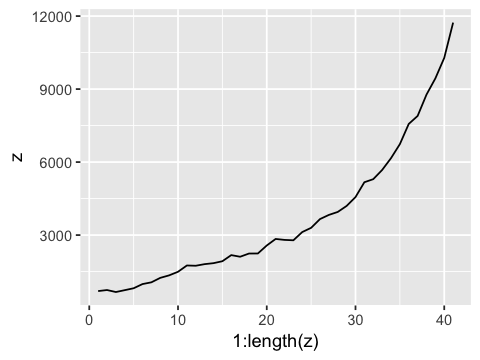

In [14]:
N = 10^6
z = c( )

for(p in probs){
    z = append(z,(1-p)*N )
    }

qplot(1:length(z),z, geom='line')

In [15]:
z[25] # страховой взнос 25-летней дамы 
# ясное дело, что недостаточно просто посмотреть на безубыточный взнос и поставить его 
# нужно ещё и на спрос смотреть, но это уже сложно и мы это делать не будем

[1] 3298

Вот такие страховые взносы. Давайте ради интереса посмотрим насколько сильно нам придётся обделить мужчин. 

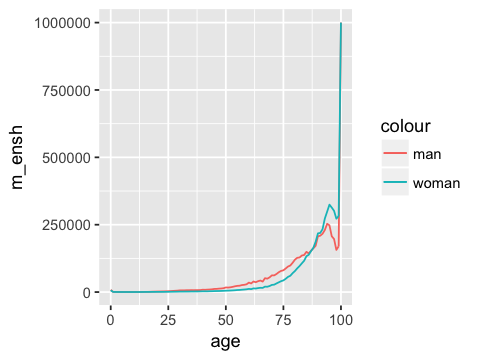

In [16]:
df['age'] = 0:100
df['w_ensh'] = (1 - df$'Женщины.город')*N
df['m_ensh'] = (1 - df$'Мужчины.город')*N

ggplot(df, aes(age))+
    geom_line(aes(y=m_ensh, colour = "man"))+
    geom_line(aes(y=w_ensh, colour = "woman"))

Мужчинам страховка обходится подороже. Мрут как мухи. Вот такая вот история по спасению красоты. 

### 2.3 Скорость работы кода 

В R можно измерить скорость работы кода. Для этого есть целый пакет. Он называется `microbenchmark`. В этом пакете есть только одна команда. Как это не удивительно, она также называется `microbenchmark`. У вас на компьютерах, скорее всего, нет этого пакета. Его нужно один разок установить командой `install.packages("microbenchmark")`. 

In [17]:
library("microbenchmark")

Эта команда прогоняет код, который находится внутри неё $100$ раз и выдаёт кучу разной информации об этих прогонах. Зачем $100$ раз? Дело в том, что время работы кода является случайной величиной. Компьютер это живой организм, внутри которого происходит огромное количество разных процессов. Возможно, что при конкретном прогоне кода, у вас на заднем фоне заиграл шикарный бит из [альбома, записанного для фильма Чёрная Пантера,](https://music.yandex.ru/album/5040468) и из-за этого программа работала немного дольше, чем обычно. Нам бы хотелось узнать медианное время работы кода. 

Например, посмотрим как долго работает операция "Квадратный корень". 

In [18]:
x = sample(100)

t <- microbenchmark(
  sqrt(x),
  x ^ 0.5
)

print(t)

Unit: microseconds
    expr   min     lq     mean median    uq      max neval
 sqrt(x) 1.045 1.0850 11.65188  1.112 1.161 1049.925   100
   x^0.5 6.000 6.0435  6.15289  6.071 6.130   12.112   100


Забавно но встроенная команда `sqrt` извлекает квадратный корень намного быстрее, чем команда `x^0.5`. Как думаете с чем это связано? 

В протоколе кроме среднего выводится ещё и медиана. Медиана - это когда половина результатов эксперимента больше, а половина меньше этой цифры. Она довольно часто используется в статистике - зарплату по регионам корректнее сравнивать не среднюю, а медианную, потому что очень маленькие или очень большие зарплаты искажают реальную картину. А на медиану они не влияют. Говорят, что медиана устойчива к выбросам.  

Давайте попробуем посмотреть на распределения времени работы кода. В этом распределении чётко можно увидеть выбросы. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


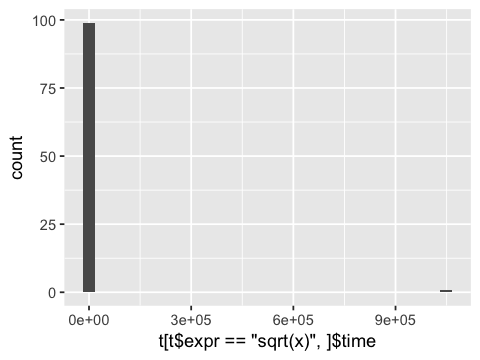

In [19]:
qplot(t[t$expr == 'sqrt(x)',]$time)

Также можно построить на одном графике сразу обе плотности распределения. Они будут красивого кремового цвета.

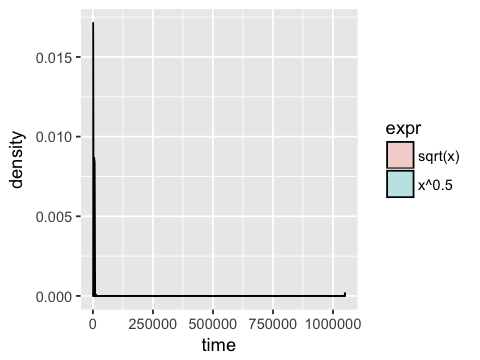

In [20]:
ggplot(t, aes(x=time, fill=expr)) + geom_density(alpha=0.25)

Для этого пакета можно построить картинки с названием виолончель! На них можно увидеть где примерно концентрируются значения случайной величины.

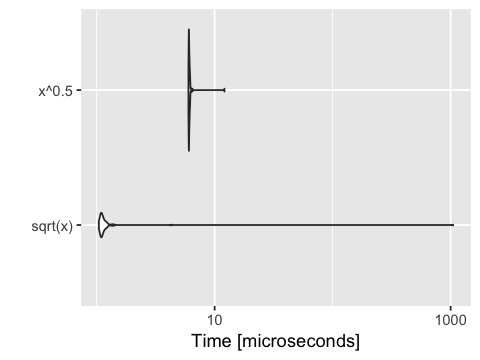

In [21]:
autoplot(t)

Про визуализации мы позже поговорим отдельно. Если вы не понимаете как делать их, не расстраивайтесь! Это почти всегда гуглинг и копи-паста уже готового кода с минимальными правками. 

## 3. Монте-Карло 

Мо́нте-Ка́рло (монегасский Monte-Carlu, фр. Monte-Carlo) — административная территория княжества Монако, крупнейший район страны, расположенный на территории одноименной коммуны в Монако. Город известен своими казино, пляжами и пользуется популярностью у представителей высшего общества. В Монте-Карло начинается и завершается ежегодное ралли «Монте-Карло».

![Фото Монте-Карло](http://seductrice.ru/public-pics/2016/11/monte-carlo_vecher.jpg)

Так говорит Википедия. Но мы будем говорить про метод работы со случайными числами, которые раньше генерировали рулеткой, коих много в Монте-Карло.

## Метод Монте-Карло для поиска площади фигуры 

Как найти площадь под графиком $\cos(x)$ от $0$ до $\pi/2$. Можно вспомнить, что это $\sin(\pi/2) - \sin(0) = 1$. Но допустим, все лекции и семинары по матану вы прогуляли. Тогда можно поступить так: Впишем график в прямоугольник $(0,0) : (\pi/2,1)$, он точно весь туда помещается. И теперь сгенерируем парочку точек в этом прямоугольнике.  

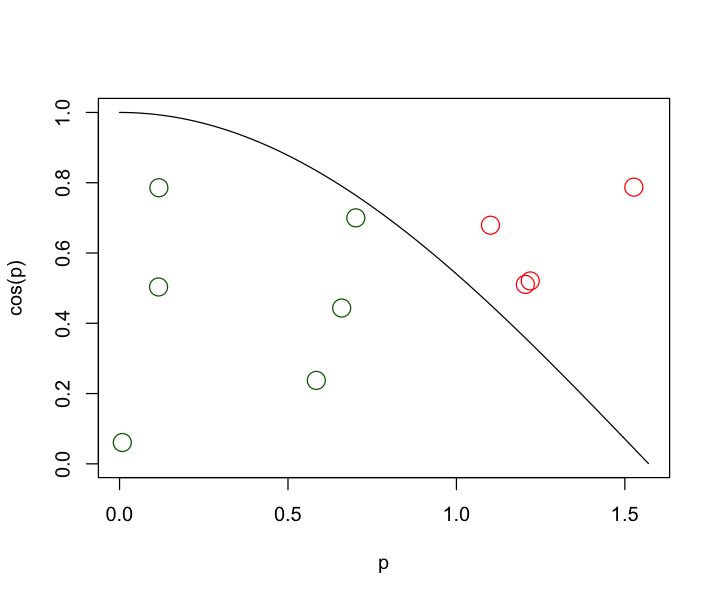

In [22]:
options(repr.plot.width=6, repr.plot.height=5)

p <- seq(0,pi/2, by=0.005)
plot(p, cos(p), type="l") # график
x <- runif(10, min=0, max=pi/2)
y <- runif(10, min=0, max=1)
points(x, y, col=ifelse(y > cos(x),"red","darkgreen"), cex=2)

Площадь всего прямоугольника будет равна $1 \cdot \pi/2 = \pi/2$. Заметим, что только часть точке попала под кривую. Утверждается, что доля точек, лежащих под кривой, умноженная на площадь прямоугольника стремится к истинной площади под кривой. Продемонстрирую свою мысль:

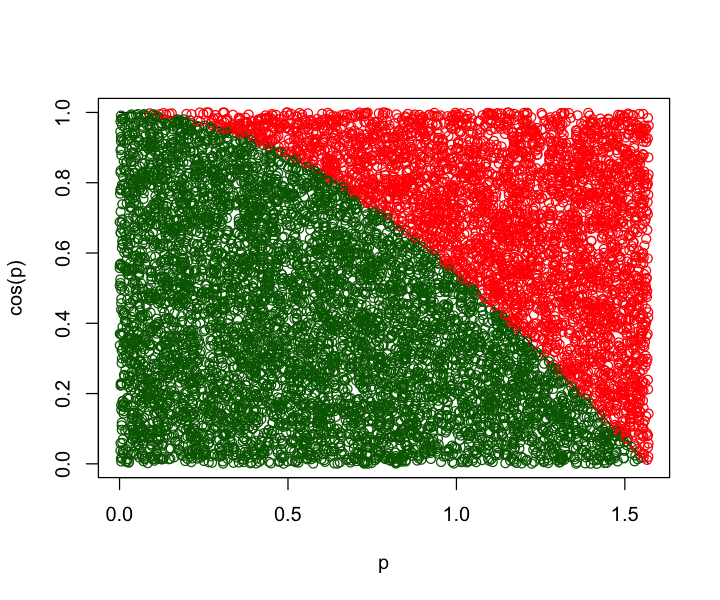

In [23]:
plot(p, cos(p), type="l")
x <- runif(10^4, min=0, max=pi/2)
y <- runif(10^4, min=0, max=1)
points(x, y, col=ifelse(y > cos(x),"red","darkgreen"))

In [24]:
sum(y<cos(x))/10^4 * pi/2

[1] 0.9905442

## 4. Решение задач на поиск вероятностей

Часто перед нами встают различные задачи, в которых нужно найти вероятность. Часто это комбинаторные задачи. Часто мы не до конца уверены правильно ли мы решили задачу. Очень легко проверить себя с помощью симуляций! Давайте попробуем решить несколько задач руками и с помощью симуляций. 

### 4.1 Номер телефона 

Известно, что в пятизначном номере телефона все цифры разные. Какова вероятность того, что при этом условии среди них только одна цифра чётная (номер может начинаться с нуля)? 

In [25]:
# генерируем номер телефона
sample(size = 5, 0:9, replace = FALSE)

[1] 0 3 4 2 7

In [26]:
# проверяем все цифры на чётность 
sample(size = 5, 0:9, replace = FALSE) %% 2

[1] 0 1 0 0 1

In [27]:
# смотрим сколько в сумме нечётных цифр
sum(sample(size = 5, 0:9, replace = FALSE) %% 2)

[1] 3

In [28]:
# и всё это в цикле!
n_obs = 10^6

m = 0
for( i in 1:n_obs){
    # если 4 нечётные, значит одна чётная
    if(sum(sample(size = 5, 0:9, replace = FALSE) %% 2) == 4){
        m = m + 1
    }
}

m/n_obs

[1] 0.099445

In [29]:
# Настоящая вероятность: 
(5*5*5*4*3*2)/(10*9*8*7*6)

[1] 0.09920635

### 4.2 Море и спортсмены 

Для $20$ участников соревнований, среди которых $8$ российских, в гостинице забронировано $20$ номеров. Из них $12$ с видом на море. Участники соревнований наугад получают ключи от номернов. Найдите вероятность того, что номера с видом на море достанутся всем российским спортсменам. 

In [30]:
# вектор номеров
room = c(rep('море',12),rep('пустошь',8))
room

[1] "море"    "море"    "море"    "море"    "море"    "море"    "море"   
 [8] "море"    "море"    "море"    "море"    "море"    "пустошь" "пустошь"
[15] "пустошь" "пустошь" "пустошь" "пустошь" "пустошь" "пустошь"

In [31]:
# вектор спортсменов 
sport = c(rep('россиянин',8),rep('иностранец',12))
sport 

[1] "россиянин"  "россиянин"  "россиянин"  "россиянин"  "россиянин" 
 [6] "россиянин"  "россиянин"  "россиянин"  "иностранец" "иностранец"
[11] "иностранец" "иностранец" "иностранец" "иностранец" "иностранец"
[16] "иностранец" "иностранец" "иностранец" "иностранец" "иностранец"

In [32]:
# Достаточно перемешать либо комнаты либо спортсменов
sample(room)

[1] "море"    "море"    "море"    "море"    "пустошь" "пустошь" "море"   
 [8] "пустошь" "море"    "пустошь" "море"    "море"    "море"    "море"   
[15] "пустошь" "пустошь" "море"    "пустошь" "пустошь" "море"

In [33]:
# Перемешаем комнаты и соединим вектора в табличку
df = data.frame('sport'=sport, 'room' = sample(room))
head(df)

sport,room
россиянин,море
россиянин,море
россиянин,пустошь
россиянин,пустошь
россиянин,море
россиянин,море


In [34]:
# осталось только сделать срез по россиянам 
df[df$sport == 'россиянин',]

sport,room
россиянин,море
россиянин,море
россиянин,пустошь
россиянин,пустошь
россиянин,море
россиянин,море
россиянин,море
россиянин,море


In [35]:
# И понять все ли они на море 
sum(df[df$sport == 'россиянин',]$room == 'море') == 8

[1] FALSE

In [36]:
# объединяем всё это в цикл!
n_obs = 1000

# комнаты
room = c(rep('море',12),rep('пустошь',8))
# спортсмены
sport = c(rep('россиянин',8),rep('иностранец',12))


m = 0
for(i in 1:n_obs){
    df = data.frame('sport'=sport, 'room' = sample(room))
    # если море встретилось у каждого россиянина, делаем плюс один
    if(sum(df[df$sport == 'россиянин',]$room == 'море') == 8){
        m = m + 1
    }
    
}

m/n_obs

[1] 0.003

In [37]:
# Можно избавиться от всяких табличек. Это довольно сильно ускорит работу кода.
# Просто будем считать что первые 8 позиций вектора относятся к россиянам

n_obs = 10^6

# комнаты
room = c(rep('море',12),rep('пустошь',8))

m = 0
for(i in 1:n_obs){
    if(sum(sample(room)[1:8] == 'море') == 8){
        m = m + 1
    }
}

m/n_obs

[1] 0.003952

In [38]:
# Теоретическая вероятность: 
factorial(12)*factorial(12)*factorial(8)/(factorial(8)*factorial(4)*factorial(20))

[1] 0.003929507

### 4.3 Шнур

На шнуре длиной $1$ м случайным образом делают два разреза. С какой вероятностью хотя бы один из получившихся кусков будет длиннее $0.5 м$?

In [39]:
X1 = runif(1,min = 0, max = 1)  # первый надрез 
X2 = runif(1,min = 0, max = 1)  # второй надрез
X1 
X2

[1] 0.6774717

[1] 0.9407576

In [40]:
n_obs <- 10^6  # чисор шнуров для кромсания

m <- 0     # сюда будем записывать правильно покромсаное количество
for(i in 1:n_obs){
    X1 = runif(1,min = 0, max = 1)  # симулируем первый разрез 
    X2 = runif(1,min = 0, max = 1)  # симулируем второй разрез 
    
    # смотримна длины всех частичек шнура 
    if(X2 > X1){
        
        # возможны 2 ситуации, когда X2 > X1 и наоборот
        m = m + 1*((1 - X2 > 0.5)|(X2 - X1 > 0.5)|(X1 - 0 > 0.5))  # если хотя бы один кусок длиннее 0.5, получаем 1
    }else{
        m = m + 1*((1 - X1 > 0.5)|(X1 - X2 > 0.5)|(X2 - 0 > 0.5))  
    }
}

m # посмотрим сколько шнуров были искромсаны удачнл

[1] 750250

In [41]:
m/n_obs

[1] 0.75025

In [42]:
# теоретическую искать мне лень

### 4.4 Колода карт

Лера довольно азартна. Она берёт карты из хорошо перемешанной колоды с 36 картами до тех пор, пока не возьмёт даму пик. Сколько в среднем бубновых карт она наберёт? Допустим, что каждая карта приносит Лере выигрыш согласно достоинству: шестёрка - 6 рублей, ..., десятка - 10 рублей, валет - 11 рублей, дама - 12 рублей и т.д. Какова вероятность того, что Лера наберёт меньше $100$ очков? Каков её средний выигрыш? 

In [43]:
n <- 10^6
dost <- factor(c(6:10,"валет","дама","король","туз")) # возможные достоинства карт
mast <- factor(c("бубны","черви","пики","крести")) # возможные масти

In [44]:
# табличка соответствий между кодом карты, мастью и очками за ее получение
koloda <- expand.grid(dost,mast) # узнаешь ли ты Дездемона, декартово произведение?
head(koloda)

Var1,Var2
6,бубны
7,бубны
8,бубны
9,бубны
10,бубны
валет,бубны


In [45]:
koloda$id <- 1:36
koloda$value <- rep(6:14,4)

# приемлимые названия столбцов
colnames(koloda) <- c("dost","mast","id","value")

head(koloda,7)

dost,mast,id,value
6,бубны,1,6
7,бубны,2,7
8,бубны,3,8
9,бубны,4,9
10,бубны,5,10
валет,бубны,6,11
дама,бубны,7,12


In [46]:
tail(koloda,5)

,dost,mast,id,value
32,10,крести,32,10
33,валет,крести,33,11
34,дама,крести,34,12
35,король,крести,35,13
36,туз,крести,36,14


In [47]:
# Возьмём 4 карты из колоды:
z <- sample(1:36,4) # коды вытянутых карт
z

[1]  4  5  9 29

In [48]:
koloda[z,]

,dost,mast,id,value
4,9,бубны,4,9
5,10,бубны,5,10
9,туз,бубны,9,14
29,7,крести,29,7


In [49]:
s <- rep(0, times = n) # s - это вектор из n штук нулей
str(s)

 num [1:1000000] 0 0 0 0 0 0 0 0 0 0 ...


In [50]:
for (i in 1:n) {
  z <- sample(1:36,36) # тасуем колоду
  
  # 25 - код пиковой дамы в таблице koloda
  k.dama <- which(z==25) # координата дамы
  
  do.damy <- z[1:(k.dama-1)] # коды карт до дамы
  s[i] <- sum(koloda$value[do.damy]) # полученный выигрыш в i-ом опыте

}

In [51]:
mean(s) # средний выигрыш за n опытов
sd(s) # стандартное отклонение выигрыша за одну партию

[1] 174.5057

[1] 102.8777

In [52]:
# Как часто выигрыш оказывался больше 100? 
sum(s > 100)/n

[1] 0.705953

Надеюсь, что за сегодня мы многое поняли! На пока что это всё. 